In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import RegularGridInterpolator
import time

import sys
sys.path.append('../')

from adasubtraction.waveeqmod import Acoustic2DDevito

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use('default')

In [2]:
nx, nz = 101, 101 # grid 
dx, dz = 12, 10
origin = (0., 0.) 

shape = (nx, nz) 
spacing = (dx, dz)

In [3]:
v = np.empty(shape, dtype=np.float32)  
v[:, :31] = 3000
v[:, 31: 51] = 3800
v[:, 51:] = 4500

v_dw = 3000 * np.ones_like(v)

In [4]:
# 插值
# x = np.arange(nx) * dx  # 水平方向原始坐标（单位：米）
# z = np.arange(nz) * dz  # 深度方向原始坐标（减去顶部2层，单位：米）
# xint = np.arange(x[0], x[-1], 10)  # 水平方向新的坐标，间隔为10米
# zint = np.arange(z[0], z[-1], 10)  # 深度方向新的坐标，间隔为10米
# nxint, nzint = len(xint), len(zint)  # 新网格的点数
# X, Z = np.meshgrid(xint, zint, indexing='ij')
# XZ = np.vstack((X.ravel(), Z.ravel())).T
# interpolator = RegularGridInterpolator((x, z), v.T, bounds_error=False)
# v_interp = interpolator(XZ).reshape(nxint, nzint).T
# v_interp.shape

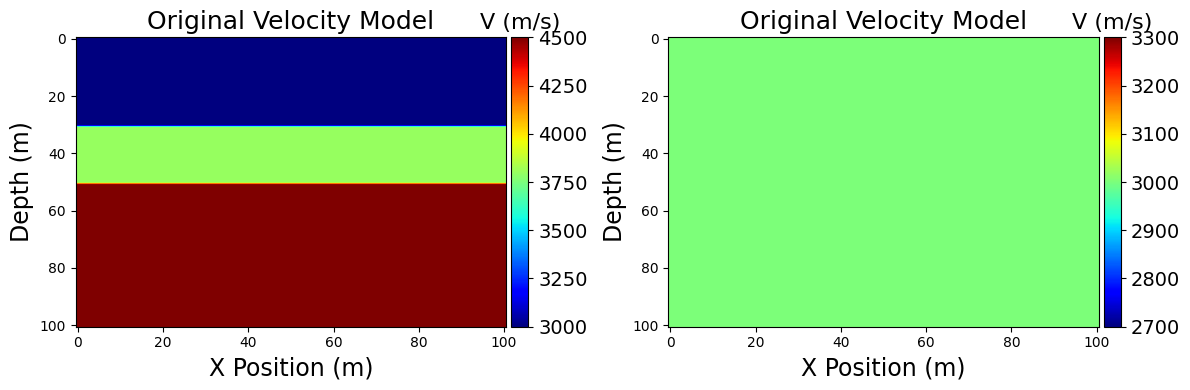

In [5]:
# Create figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

im0 = axs[0].imshow(v.T, cmap='jet')
axs[0].axis('tight')
axs[0].set_title('Original Velocity Model', fontsize=18)
axs[0].set_ylabel('Depth (m)', fontsize=17)
axs[0].set_xlabel('X Position (m)', fontsize=17)
divider = make_axes_locatable(axs[0])

cax = divider.append_axes('right', size='4%', pad=0.05)
cax.set_title('V (m/s)', fontsize=16)
cax.tick_params(labelsize=14)
fig.colorbar(im0, cax=cax, orientation='vertical')
fig.colorbar(im0, cax=cax, orientation='vertical')

im1 = axs[1].imshow(v_dw.T, cmap='jet')
axs[1].axis('tight')
axs[1].set_title('Original Velocity Model', fontsize=18)
axs[1].set_ylabel('Depth (m)', fontsize=17)
axs[1].set_xlabel('X Position (m)', fontsize=17)
divider = make_axes_locatable(axs[1])

cax = divider.append_axes('right', size='4%', pad=0.05)
cax.set_title('V (m/s)', fontsize=16)
cax.tick_params(labelsize=14)
fig.colorbar(im1, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [6]:
nbl = 500
space_order = 8
t0 = 0
tn = 1200 # ms
dt = 1 # ms
f0 = 30 # Hz
fs = True # 上表面自由边界
nsrc = nx
nrec = nx
depth = 5

In [7]:
awe = Acoustic2DDevito()

# 速度模型
awe.create_model(
    shape,                 # 模型的形状（水平点数，深度点数）
    origin,                # 模型的原点位置（水平和深度均为0米）
    spacing,               # 网格间距）
    v,                     # 速度模型（需要转置以匹配内部坐标格式）
    space_order,           # 数值差分的空间阶数
    nbl=nbl,               # 模型边界层厚度
    fs=fs                  # 是否设置自由表面条件（True 表示有自由表面）
)


# 创建几何布置
awe.create_geometry(
    src_x=np.arange(0, nsrc) * spacing[0],      # 激发源的水平位置（每隔12米一个源）
    src_z=depth,                                # 激发源的深度位置（固定在5米深度）
    rec_x=np.arange(0, nrec) * spacing[0],      # 接收器的水平位置（每隔12米一个接收器）
    rec_z=depth,                                # 接收器的深度位置（固定在5米深度）
    t0=t0,                                      # 模拟的起始时间（毫秒）
    tn=tn,                                      # 模拟的总时间（毫秒）
    src_type='Ricker',                          # 激发源的类型（Ricker wavelet）
    f0=f0                                       # 激发源的主频率（25 Hz）
)

# 打印时间步长
# geometry.dt 是计算得到的时间步长（由模型参数和 CFL 条件决定）
print(awe.geometry.dt)

Operator `initdamp` ran in 0.01 s


1.153


In [8]:
awe_dw = Acoustic2DDevito()

# 速度模型
awe_dw.create_model(
    shape,                 # 模型的形状（水平点数，深度点数）
    origin,                # 模型的原点位置（水平和深度均为0米）
    spacing,               # 网格间距）
    v_dw,                  # 速度模型
    space_order,           # 数值差分的空间阶数
    nbl=nbl,               # 模型边界层厚度
    fs=fs                  # 是否设置自由表面条件（True 表示有自由表面）
)

awe_dw.create_geometry(
    src_x=np.arange(0, nsrc) * spacing[0],      # 激发源的水平位置（每隔12米一个源）
    src_z=depth,                                # 激发源的深度位置（固定在5米深度）
    rec_x=np.arange(0, nrec) * spacing[0],      # 接收器的水平位置（每隔12米一个接收器）
    rec_z=depth,                                # 接收器的深度位置（固定在5米深度）
    t0=t0,                                      # 模拟的起始时间（毫秒）
    tn=tn,                                      # 模拟的总时间（毫秒）
    src_type='Ricker',                          # 激发源的类型（Ricker wavelet）
    f0=f0                                       # 激发源的主频率（25 Hz）
)


# 打印时间步长
# geometry.dt 是计算得到的时间步长（由模型参数和 CFL 条件决定）
print(awe_dw.geometry.dt)

Operator `initdamp` ran in 0.01 s


1.73


In [9]:
# 选择中间的激发源（即选择模型中间的一个源）
isrc = (nsrc // 2) + 1 # 激发源的索引，选择中间的源（nsrc 是源的总数）
print(isrc)

# 执行一次正演模拟，使用指定的激发源
# awe.solve_one_shot 计算一次正演模拟，返回激发源为 isrc 时的数据
# dt 是时间步长，用于数值计算
tdata, _, _ = awe.solve_one_shot(isrc, dt=dt)
data = tdata.data

dw, _, _ = awe_dw.solve_one_shot(isrc, dt=dt)
dw_data = dw.data

data_cut_dw = data - dw_data

data.shape

51


Operator `Forward` ran in 0.76 s
Operator `Forward` ran in 0.48 s


(1202, 101)

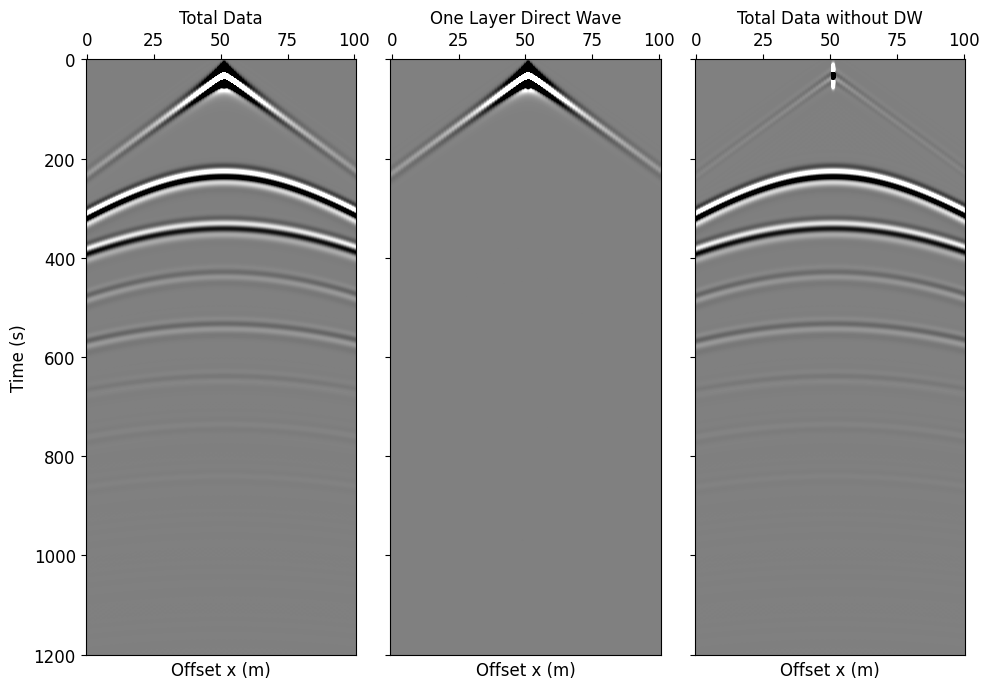

In [ ]:
vmax = 1e-1
vmin = -vmax

fig, axs = plt.subplots(1, 3, figsize=(10, 7),sharey=True)

axs[0].imshow(data, aspect='auto', vmin=vmin, vmax=vmax, cmap='grey')
axs[0].set_title('Total Data',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=12)
axs[0].set_ylabel('Time (s)',fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[1].imshow(dw_data, aspect='auto', vmin=vmin, vmax=vmax, cmap='grey')
axs[1].set_title('One Layer Direct Wave',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=12)
axs[1].tick_params(axis='x', labelsize=12)
axs[2].imshow(data_cut_dw, aspect='auto', vmin=vmin, vmax=vmax, cmap='grey')
axs[2].set_title('Total Data without DW',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=12)
axs[2].tick_params(axis='x', labelsize=12)

plt.tight_layout()
axs[0].xaxis.set_ticks_position('top')
axs[1].xaxis.set_ticks_position('top')
axs[2].xaxis.set_ticks_position('top')

In [11]:
def mutter(input, x0, t0, k1, k2):
    n1, n2 = input.shape
    print(input.shape)
    output = input.copy()
    
    for i in range(n1):
        for j in range(n2):
            # Apply conditions for j < x0 (left side)
            if j < x0:
                if i - 100 < np.floor(-k1 * j + t0 + k1 * x0):
                    output[i, j] = 0
            # Apply conditions for j >= x0 (right side)
            if j >= x0:
                if i - 100 < np.floor(k2 * j + t0 - k2 * x0):
                    output[i, j] = 0
    
    return output

In [12]:
data_mutter = mutter(data, isrc, depth, 3, 3)

(1202, 101)


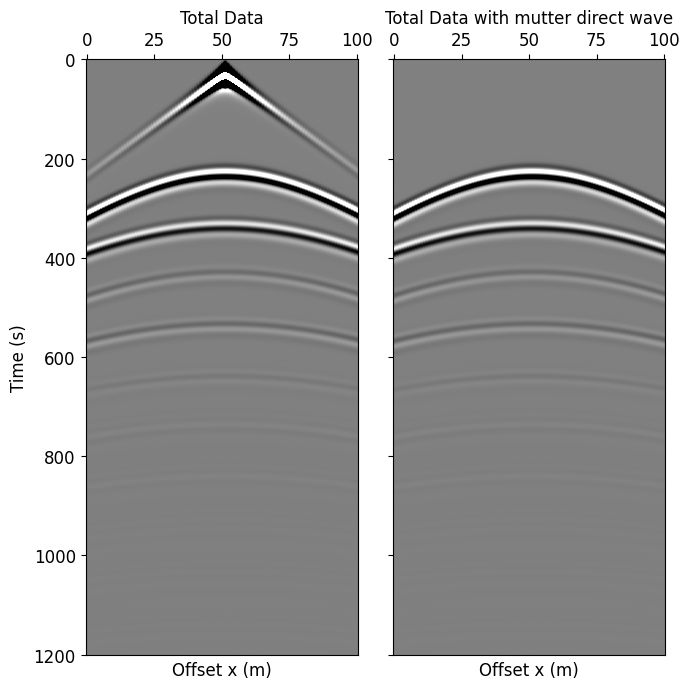

In [13]:

fig, axs = plt.subplots(1, 2, figsize=(7, 7),sharey=True)
axs[0].imshow(data, aspect='auto', vmin=vmin, vmax=vmax, cmap='grey')
axs[0].set_title('Total Data',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=12)
axs[0].set_ylabel('Time (s)',fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

axs[1].imshow(data_mutter, aspect='auto', vmin=vmin, vmax=vmax, cmap='grey')
axs[1].set_title('Total Data with mutter direct wave',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=12)
axs[1].tick_params(axis='x', labelsize=12)

plt.tight_layout()
axs[0].xaxis.set_ticks_position('top')
axs[1].xaxis.set_ticks_position('top')

In [14]:
# Total data

start_time = time.time()/60

dtot, _ = awe.solve_all_shots(dt=dt, savedtot=True) 

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

100%|██████████| 101/101 [04:33<00:00,  2.71s/it]

--- 4.566 minutes ---


In [15]:
# Total data direct wave

start_time = time.time()/60

dw_tot, _ = awe_dw.solve_all_shots(dt=dt, savedtot=True)  

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

  0%|          | 0/101 [00:00<?, ?it/s]

Operator `Forward` ran in 0.45 s
100%|██████████| 101/101 [04:06<00:00,  2.44s/it]

--- 4.113 minutes ---


In [16]:
# Subtract direct wave
d_nodw_tot = dtot - dw_tot

# Save 3d numpy array
np.savez('../data/data_free.npz', d_nodw_tot)